# 0 - Rotate input grids into the optimised Muller2022 frame

The Muller et al. 2022 rotation model is built on an optimised reference frame. The following input grids must be rotated into this frame (it not already) to run the notebooks in this workflow with the Muller et al. 2022 model:

* Seafloor age grids
* Spreading rate grids
* Total sediment thickness grids
* Contoured continent mask grids - continent masks with an added buffer around continents to account for continental arcs. 

#### NOTE: while there is a cell in this notebook to rotate continent contoured masks, the corresponding subduction zone, continent polygon and passive margin feature gpmlz files are not rotated. Therefore, it is prefereable to run the continent contouring workflow for the Muller2022 model from scratch. 

* Carbonate sediment thickness grids
* Crustal carbon grids


In [1]:
import numpy as np
import gplately.pygplates as pygplates
import ptt
import gplately
import gplately.tools as tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
import warnings
from scipy import ndimage
import glob, os
from rasterio.features import rasterize
from rasterio.transform import from_bounds

In [2]:
from joblib import Parallel, delayed
import joblib

In [3]:
# Access the Merdith2021 plate model
m21 = gplately.download.DataServer("Merdith2021")
m21_rotation_model, m21_topology_features, m21_static_polygons = m21.get_plate_reconstruction_files()
m21_coastlines, m21_continents, m21_COBs = m21.get_topology_geometries()

# Access the Muller2022 optimised plate model
m22 = gplately.download.DataServer("Muller2022")
m22_rotation_model, m22_topology_features, m22_static_polygons = m22.get_plate_reconstruction_files()
m22_coastlines, m22_continents, m22_COBs = m22.get_topology_geometries()



# For our Merdith et al. (2021) analysis we have grids at the following times.
min_time = 0
max_time = 1000
timestep_size = 1
reconstruction_times = np.arange(max_time, min_time-timestep_size, -timestep_size)


# Start with the Merdith et al. (2021) paleomagnetic reference frame (plate_id = 0)
from_rotation_files = m21_rotation_model.filenames
from_rotation_reference_plate = 0

# Rotate using the Muller et al. (2022) mantle reference frame (plate_id = 0)
to_rotation_files = m22_rotation_model.filenames
to_rotation_reference_plate = 0


# Any plate that is not a reference plate. This is needed so that we can obtain a 
# rotation from each model relative to its reference plate.
non_reference_plate = 701

# Input and output grid sample spacing (in degrees).
grid_spacing_degrees = 0.5

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!
No continent-ocean boundaries in Merdith2021.
Checking whether the requested files need to be updated...
Requested files are up-to-date!
No static polygons in Muller2022.
Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [4]:
# Input and output grids.
# Change this: directory to folder CO2_Review_Bundle
hard_drive = "Carbon"
bundle_parent_directory = "/Volumes/{}/".format(hard_drive)

parent_directory = bundle_parent_directory+"CO2_review_Bundle/"

input_directory = parent_directory+ "CO2_review_inputs/"
output_directory = parent_directory+ "CO2_review_outputs/"

## Define a function to rotate grids using `gplately`'s `rotate_reference_frames` function

In [5]:
def rotate_grid(input_grid_filename, reconstruction_time, output_name):
    
    
    rasterobj = gplately.grids.Raster(
        #input_grid_filename.format(component, quantity, component.lower(), reconstruction_time), time=reconstruction_time)
        input_grid_filename, time=reconstruction_time)

    hi = rasterobj.rotate_reference_frames(

        grid_spacing_degrees=0.5,
        reconstruction_time=reconstruction_time,
        from_rotation_features_or_model=from_rotation_files,
        to_rotation_features_or_model=to_rotation_files,
        from_rotation_reference_plate=0,
        to_rotation_reference_plate=0,
        non_reference_plate=701,
        output_name=output_name,

    )
    return

### 1. Rotate Seafloor Age grids

In [9]:
# Input file directory - Merdith2021 seafloor age grids
grid_directory = "/Volumes/{}/Merdith_etal_2021_input_grids/SeafloorAge".format(hard_drive)
input_grid_filename = grid_directory+"/Merdith2021_SEAFLOOR_AGE_grid_{:.1f}Ma.nc"

# Output file directory - Muller2022 seafloor age grids
output_grid_directory = "/Volumes/{}/Muller2022_RotatedGrids/SeafloorAge/".format(hard_drive)
os.makedirs(output_grid_directory, exist_ok=True)
output_grid_filename = output_grid_directory+"Muller2022_SEAFLOOR_AGE_grid_{:.1f}Ma.nc"

In [10]:
converted_frames = Parallel(n_jobs=-2, backend='loky', verbose=1) \
    (delayed(rotate_grid) \
(
    input_grid_filename = input_grid_filename.format(reconstruction_time),
    reconstruction_time=reconstruction_time,
    output_name=output_grid_filename.format(reconstruction_time),
)
     for i, reconstruction_time in enumerate(reconstruction_times))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:  2.4min finished


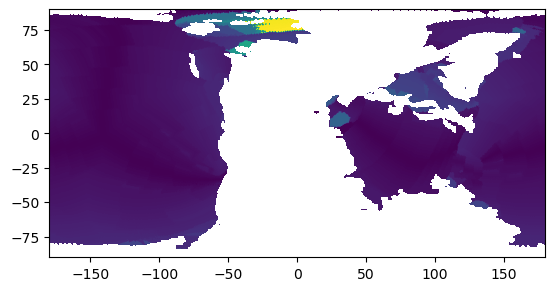

In [11]:
reconstruction_time = 200
gplately.Raster(
    output_grid_filename.format(reconstruction_time)
).imshow()

### 2. Rotate Spreading Rate grids

In [30]:
# Input file directory - Merdith2021 spreading rate grids
grid_directory = "/Volumes/{}/Merdith_etal_2021_input_grids/SpreadingRate".format(hard_drive)
input_grid_filename = grid_directory+"/Merdith2021_SPREADING_RATE_grid_{:.1f}Ma.nc"

# Output file directory - Muller2022 spreading rate grids
output_grid_directory = "/Volumes/{}/Muller2022_RotatedGrids/SpreadingRate/".format(hard_drive)
os.makedirs(output_grid_directory, exist_ok=True)
output_grid_filename = output_grid_directory+"Muller2022_SPREADING_RATE_grid_{:.1f}Ma.nc"

In [25]:
converted_frames = Parallel(n_jobs=-2, backend='loky', verbose=1) \
    (delayed(rotate_grid) \
(
    input_grid_filename=input_grid_filename.format(reconstruction_time),
    reconstruction_time=reconstruction_time,
    output_name=output_grid_filename.format(reconstruction_time),
)
     for i, reconstruction_time in enumerate(reconstruction_times))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:  2.5min finished


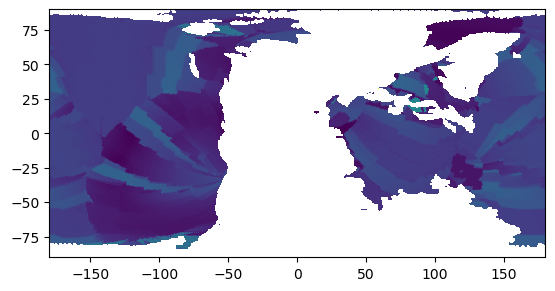

In [31]:
reconstruction_time = 200
gplately.Raster(
    output_grid_filename.format(reconstruction_time)
).imshow()

### 3. Rotate the total sediment thickness grids

For the Merdith2021 model, we only have total sediment thickness from 0-541Ma. All other timesteps assume 0 sediment thickness. To maintain workflow continuity we use the buffered continental outlines (produced using PlateTectonicTools' [Continent Contouring workflow](https://github.com/EarthByte/PlateTectonicTools/blob/master/ptt/continent_contours.py)) as placeholder grids to read in these timesteps, but the workflow makes all ocean points have values of 0. 

In [32]:
# Input file directory - Merdith2021 total sediment thickness grids
grid_directory = "/Volumes/{}/Merdith_etal_2021_input_grids/TotalSediment".format(hard_drive)
input_grid_filename = grid_directory+"/sed_thick_0.1d_{}.nc"

# Output file directory - Muller2022 total sediment thickness grids
output_grid_directory = "/Volumes/{}/Muller2022_RotatedGrids/TotalSediment/".format(hard_drive)
os.makedirs(output_grid_directory, exist_ok=True)
output_grid_filename = output_grid_directory+"Muller2022_sed_thick_0.1d_{:.1f}Ma.nc"

In [33]:
converted_frames = Parallel(n_jobs=-2, backend='loky', verbose=1) \
    (delayed(rotate_grid) \
(
    input_grid_filename=input_grid_filename.format(reconstruction_time),
    reconstruction_time=reconstruction_time,
    output_name=output_grid_filename.format(reconstruction_time),
)
     for i, reconstruction_time in enumerate(np.arange(0,541,1)))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 541 out of 541 | elapsed:  1.5min finished


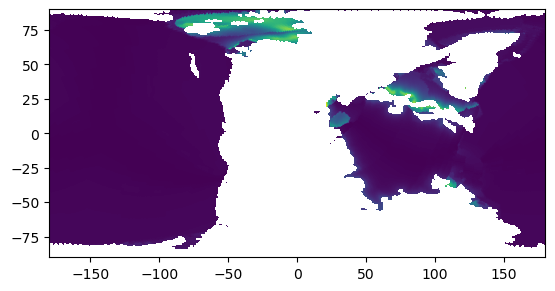

In [34]:
reconstruction_time = 200
gplately.Raster(
    output_grid_filename.format(reconstruction_time)
).imshow()

### 4. Rotate continent contoured masks

Based on the [continent contouring workflow](https://github.com/EarthByte/PlateTectonicTools/blob/master/ptt/continent_contours.py), the continent contouring standard solution is:

- continent_exclusion_area_threshold_square_kms = 900000
- continent_separation_distance_threshold_radians = 0.00025
- pre_pangea_distance_radians = math.radians(2.25)
- area_threshold_square_kms = 500000
- Grid spacing = 0.1

### NOTE that the files: 
* passive_margin_features.gpmlz
* subduction_zone_features.gpmlz
* continent_contour_features.gpmlz

...cannot be rotated in this method, so it is preferable that the continent contouring workflow is rerun for the Muller2022 model.

In [35]:
# Input file directory - Merdith2021 contoured continent mask grids
grid_directory = "/Volumes/{}/Merdith_etal_2021_input_grids/ContouredContinent".format(hard_drive)
input_grid_filename = grid_directory+"/continent_mask_{:.1f}.nc"

# Output file directory - Muller2022 contoured continent mask grids
output_grid_directory = "/Volumes/{}/Muller2022_RotatedGrids/ContinentalMasks/".format(hard_drive)
os.makedirs(output_grid_directory, exist_ok=True)
output_grid_filename = output_grid_directory+"Muller2022_continent_mask_{:.1f}.nc"

In [36]:
converted_frames = Parallel(n_jobs=-2, backend='loky', verbose=1) \
    (delayed(rotate_grid) \
(
    input_grid_filename=input_grid_filename.format(reconstruction_time),
    reconstruction_time=reconstruction_time,
    output_name=output_grid_filename.format(reconstruction_time),
)
     for i, reconstruction_time in enumerate(reconstruction_times))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:  3.0min finished


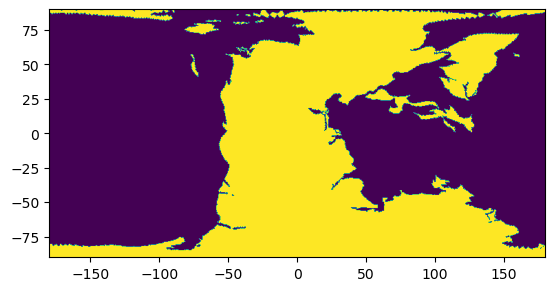

In [37]:
reconstruction_time = 200
gplately.Raster(
    output_grid_filename.format(reconstruction_time)
).imshow()

### 5. Rotate Carbonate sediment thickness grids

In [38]:
# Input file directory - Merdith2021 carbonate sediment thickness grids
grid_directory = "/Volumes/{}/Merdith_etal_2021_input_grids/CarbonateSediment".format(hard_drive)
input_grid_filename = grid_directory+"/{}/decompacted_sediment_thickness_0.5_cobmasked_{}.nc"

# Output file directory - Muller2022 carbonate sediment thickness grids
output_grid_directory = "/Volumes/{}/Muller2022_RotatedGrids/CarbonateSediment/".format(hard_drive)
os.makedirs(output_grid_directory, exist_ok=True)

In [39]:
reconstruction_time = 0
for quantity in ['Min', 'Mean', 'Max']:
    
    # Make sub folders for min, mean and max output sed thickness
    os.makedirs(output_grid_directory+"{}/".format(quantity), exist_ok=True)
    output_grid_filename = output_grid_directory+"{}/Muller2022_decompacted_sediment_thickness_0.5_cobmasked_{:.1f}Ma.nc"

    converted_frames = Parallel(n_jobs=-2, backend='loky', verbose=1) \
    (delayed(rotate_grid) \
    (
    input_grid_filename=input_grid_filename.format(quantity, reconstruction_time),
    reconstruction_time=reconstruction_time,
    output_name=output_grid_filename.format(quantity, reconstruction_time),
    )
     for i, reconstruction_time in enumerate(np.arange(0,171,1)))


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-2)]: Done 171 out of 171 | elapsed:   24.6s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-2)]: Done 171 out of 171 | elapsed:   24.8s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-2)]: Done 171 out of 171 | elapsed:   24.3s finished


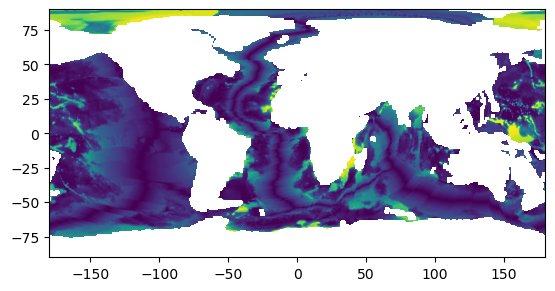

In [41]:
reconstruction_time = 0
for quantity in ['Min', 'Mean', 'Max']:
    gplately.Raster(
        output_grid_filename.format(quantity, reconstruction_time)
    ).imshow()

### 6. Rotate crustal carbon grids

In [42]:
# Input file directory - Merdith2021 carbonate sediment thickness grids
grid_directory = "/Volumes/{}/Merdith_etal_2021_input_grids/CrustalCarbon".format(hard_drive)
input_grid_filename = grid_directory+"/{}/{}/upper_crustal_CO2_{}_{}.nc"


# Output file directory - Muller2022 carbonate sediment thickness grids
output_grid_directory = "/Volumes/{}/Muller2022_RotatedGrids/CrustalCarbon/".format(hard_drive)
os.makedirs(output_grid_directory, exist_ok=True)

In [43]:
for quantity in ['min', 'mean', 'max']:
    
    for time in reconstruction_times:
        os.makedirs(output_grid_directory+"{}/{}/".format(quantity, time), exist_ok=True)

    output_grid_filename = output_grid_directory+"{}/{}/Muller2022_upper_crustal_CO2_{}_{}.nc"
    converted_frames = Parallel(n_jobs=-2, backend='loky', verbose=1) \
    (delayed(rotate_grid) \
    (
    input_grid_filename=input_grid_filename.format(quantity, reconstruction_time, quantity, reconstruction_time),
    reconstruction_time=reconstruction_time,
    output_name=output_grid_filename.format(quantity,  reconstruction_time, quantity, reconstruction_time),
    )
     for i, reconstruction_time in enumerate(reconstruction_times))


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:  2.5min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:  2.5min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:   28.5s
[Paral

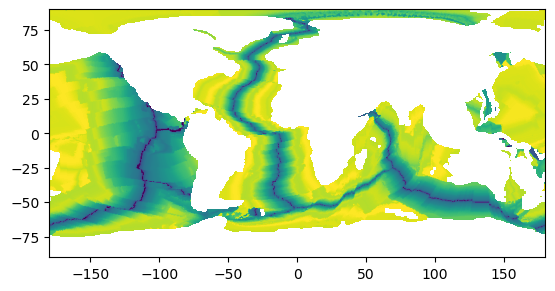

In [45]:
output_grid_filename = output_grid_directory+"{}/{}/Muller2022_upper_crustal_CO2_{}_{}.nc"
reconstruction_time = 0
for quantity in ['Min', 'Mean', 'Max']:
    gplately.Raster(
        output_grid_filename.format(quantity,  reconstruction_time, quantity, reconstruction_time)
    ).imshow()

Now, rerun all notebooks as usual.